# RespiCoV sequencing analysis by primer

Analyze fastq file(s) from nanopore sequencing output using [RespiCoV](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0264855) primers. Designed for ligation sequencting chemistry.

Run here on my second RespiCoV sequencing attempt where I knew (from gel) that I had a lot of mis-priming. The flow cell apparently got clogged and didn't return many reads. 

**Goals:**
 * Identify likely target matches per input sample, for downstream sequence alignment
 * Quantify PCR effectiveness and visualize the ways in which PCR mis-priming occurs in practice.
 * Run quickly on a single machine and scale linearly with input sequence
 * Enable iterative exploration of the data (cache the most expensive operations)
 
**Non-goals / future work elsewhere:**
 * Virus type-analysis for matches
 * Integrate Kraken / minimap2 analysis to suggest likely source of mis-priming. In particular, human matches
 * Map to human genome to study off-target mispriming in practice
 * Map reads to target genome sequences
 * Attempt to separate reads from distinct genomes pooled into the same barcode (eg. by type)
 * Use reads which only include one (or even zero) primers, eg. for tagmentation chemistry

## Initialization and configuration

In [1]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import Align
import matplotlib_inline.backend_inline
import os
import pandas as pd
import RCUtils
import random

# Get high-dpi output for retina displays
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Be deterministic
random.seed(42)

fastQBaseDir = "../RespiCov-2/20230430_1642_MN41817_APC888_8b249272/fastq_pass/"

pd.options.display.max_rows = 50
pd.options.display.min_rows = 25

primers = RCUtils.readPrimers("RespiCovPrimers.fasta")
print("Read %i primers" % (len(primers)))

# Compute and save primer matches if needed
RCUtils.generateAllHitsFiles(primers, fastQBaseDir)

def getAllPrimerMatches():
    return RCUtils.getAllPrimerMatches(primers, fastQBaseDir)

Read 115 primers
Processing  APC888_pass_barcode01_8b249272_a9170401_0.fastq.gz.....  1.62s
Processing  APC888_pass_barcode02_8b249272_a9170401_0.fastq.gz..  0.71s
Processing  APC888_pass_barcode03_8b249272_a9170401_0.fastq.gz...  1.09s
Processing  APC888_pass_barcode04_8b249272_a9170401_0.fastq.gz..  0.83s
Processing  APC888_pass_barcode05_8b249272_a9170401_0.fastq.gz.  0.53s
Processing  APC888_pass_barcode06_8b249272_a9170401_0.fastq.gz...  1.10s
Processing  APC888_pass_barcode07_8b249272_a9170401_0.fastq.gz....  1.22s
Processing  APC888_pass_barcode08_8b249272_a9170401_0.fastq.gz..  1.04s


## How many primers are found in each read?
Notable here is that, in my first experiment nearly every read included at least one primer, suggesting PCR products did dominate the results. 
Proper amplification and sequencing should typically result in 2 primers per read, which is indeed the most common result. But it's also very common to have only a single primer.
It's also not unusual to have several primers, suggesting primer-dimers.

In [2]:
from collections import Counter

readsPerPrimerCount = Counter()
readTotal = 0
for (subdir, read, hits) in getAllPrimerMatches():
    readTotal += 1
    readsPerPrimerCount[len(hits)] += 1
print("%i total reads" % readTotal)

table = pd.DataFrame.from_dict(readsPerPrimerCount, orient="index", columns=["Reads"])
table.index.name = "Primer Count"
table.sort_index(inplace=True)
table["%"] = table["Reads"].apply(lambda r: round(100 * r / readTotal, ndigits=2))
table

2589 total reads


,Reads,%
Primer Count,,
0,86,3.32
1,798,30.82
2,977,37.74
3,270,10.43
4,271,10.47
5,69,2.67
6,68,2.63
7,20,0.77
8,15,0.58


This is similar to my RC1 run but with about half the reads and 10pp fewer 2-primer reads.

## What is the distribution of primer match scores
Most hits exactly match a primer, but small numbers of mismatches are not uncommon.
In earlier testing, match scores of around 60% and lower were extremely common, purely by chance.

3087 of 5804 (53%) of primer hits are a perfect match


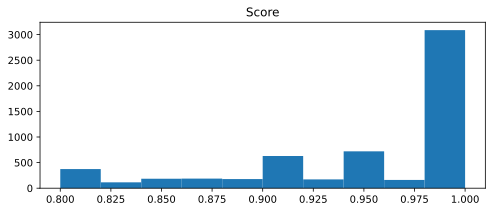

In [3]:
mrs = []
perfect = 0
for (subdir, record, hits) in getAllPrimerMatches():
    for hit in hits:
        mrs.append(hit.mr)
        if hit.mr == 1.0:
            perfect += 1

print("%d of %d (%d%%) of primer hits are a perfect match" % (perfect, len(mrs), 100*perfect/len(mrs)))
pd.DataFrame({'Score': mrs}).hist(figsize=(8,3), bins=10, grid=False);

## How often is each primer seen?
With a highly-specific PCR reaction I would expect to see the primer matches dominated by the legitimate target sequences. That's not the case here, suggesting perhaps the annealing temp was too low. More analysis is clearly needed in order to identify likely targets in the data.

,Fwd hits,Rev hits,%,Avg MR
Primer,,,,
Influenza B virus 4,203,181,6.62,0.95
Rhinovirus/Enterovirus 2,201,108,5.32,0.94
Influenza A virus 2,143,141,4.89,0.97
Hendra virus 5,150,88,4.10,0.96
Mumps orthorubulavirus 1,151,87,4.10,0.89
Human parechovirus 2,127,76,3.50,0.97
SARS coronavirus 1/2 6,114,71,3.19,0.95
Human parechovirus 1,93,70,2.81,0.97
Influenza A virus 7,91,70,2.77,0.97


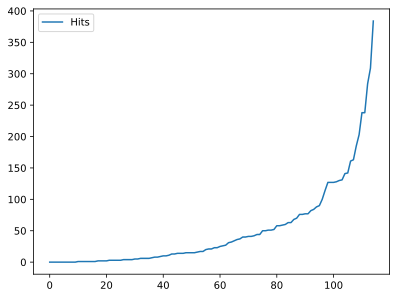

In [4]:
hitsPerPrimer = dict()
for p in primers:
    hitsPerPrimer[p.description] = [0,0,0]

hitsTotal = 0
for (subdir, record, hits) in getAllPrimerMatches():
    hitsTotal += len(hits)
    for hit in hits:
        hitsPerPrimer[hit.primer.description][1 if hit.rev else 0] += 1
        hitsPerPrimer[hit.primer.description][2] += hit.mr

def addPercent (entry):
    (primer, [fwd,rev,mrtot]) = entry
    return (primer, fwd, rev, round((fwd+rev) / hitsTotal * 100, ndigits=2), round(mrtot / (fwd+rev), ndigits=2))

allHits = sorted([f+r for (f, r, m) in hitsPerPrimer.values()])
pd.DataFrame(allHits, columns=["Hits"]).plot()

data = map(addPercent, filter(lambda p:p[1]!=[0,0,0], hitsPerPrimer.items()))
table = pd.DataFrame(data, columns=["Primer","Fwd hits", "Rev hits", "%", "Avg MR"])
table.set_index("Primer", inplace=True)
table.sort_values("%", ascending=False, inplace=True)
table

## Which primers are never seen exactly?
Given the high rate of off-target amplification in this experiment, if a primer is never seen at all, that may suggest a failure in the assay preparation
or synthesis. 

In [5]:
primerMaxMatch = dict.fromkeys(map(lambda p:p.description, primers), (0,0.0))

for (subdir, record, hits) in getAllPrimerMatches():
    for hit in hits:
        (count, maxMr) = primerMaxMatch[hit.primer.description]
        primerMaxMatch[hit.primer.description] = (count+1, max(maxMr, hit.mr))

table = pd.DataFrame.from_dict(primerMaxMatch, orient="index", columns=["Hits", "Max Match"])
table.index.name = "Primer"
table.sort_values("Max Match", ascending=False, inplace=True)
table[table["Max Match"] < 1.0]

,Hits,Max Match
Primer,,
Influenza B virus 3,3,0.96
Influenza A virus 8,1,0.96
Influenza A virus 21,1,0.96
Respirovirus 7,4,0.96
Human adenovirus 2,13,0.95
Human adenovirus 14,2,0.88
Influenza A virus 20,1,0.87
Human respiratory syncytial virus 1.0,2,0.86
Human respiratory syncytial virus 1.1,1,0.81


There's no hits to the random control primer.

The same weak Influenza and RSV hits from RC1 also show up here as weak or missing, further suggesting those primers could be missing from the primer pool. But there are additional missing primer hits here, so perhaps this just represents better priming.

## What's the distribution of read lengths per subdir
We should expect this to look similar to gel output minus some constant offset for the adapters/barcodes. Note that unlike the RC1 run, I kept the default min length of 200bp.

99 of 2589 (3%) reads are less than 200bp


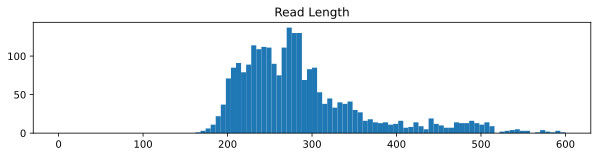

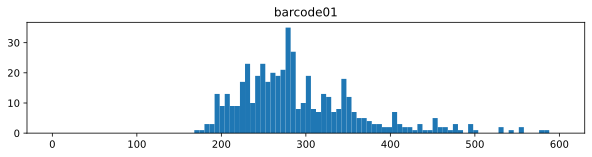

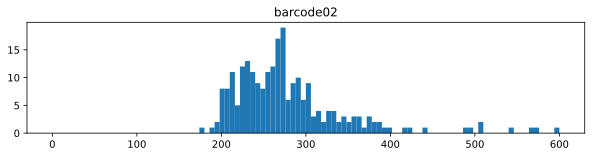

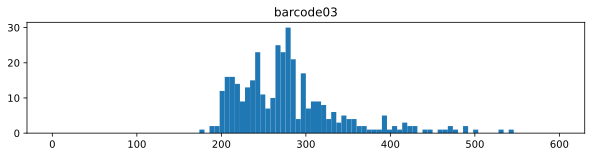

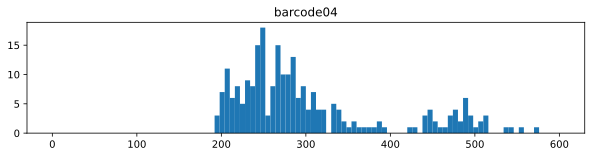

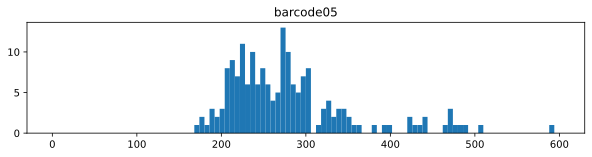

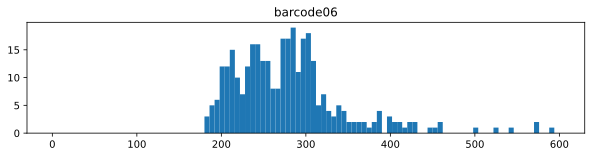

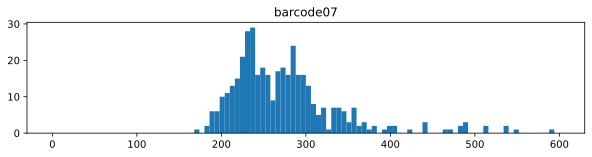

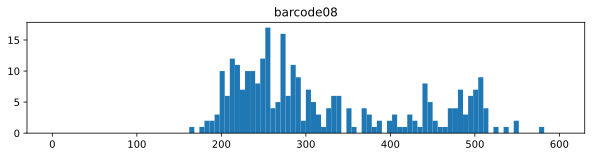

In [6]:
lessThan200 = 0
lengths=[]
for (subdir, read, hits) in getAllPrimerMatches():
    lengths.append(len(read.seq))
    if len(read.seq) < 200:
        lessThan200 += 1
pd.DataFrame({'Read Length': lengths}).hist(bins=100, figsize=(10,2), grid=False, range=(0,600));
print ("%d of %d (%d%%) reads are less than 200bp" % (lessThan200, len(lengths), 100*lessThan200/len(lengths)))

for fastQDir in RCUtils.getAllFastQDirs(fastQBaseDir):
    lengths=[]
    for (read, hits) in RCUtils.getPrimerMatches(primers, fastQDir):
        lengths.append(len(read.seq))
    subdir=os.path.basename(fastQDir)
    pd.DataFrame({subdir: lengths}).hist(bins=100, figsize=(10,2), grid=False, log=False, range=(0,600));    

Reads are relatively evenly distributed by barcode. 

## What's the distribution of primer positions?

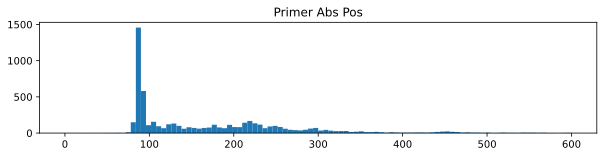

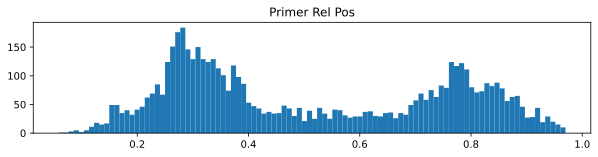

In [7]:
paPos=[]
prPos=[]

for (subdir, read, hits) in getAllPrimerMatches():
    paPos += map(lambda hit: hit.end, hits)
    prPos += map(lambda hit: (hit.start+hit.end)/2/len(read.seq), hits)

pd.DataFrame({'Primer Abs Pos': paPos}).hist(bins=100, figsize=(10,2), grid=False, range=(0,600))
pd.DataFrame({'Primer Rel Pos': prPos}).hist(bins=100, figsize=(10,2), grid=False);

The bimodal relative position may be because the most common pattern is a barcode prefix, primer, match region of arbitrary (but often low) length, primer and barcode suffix. 

## What is the distance between primer hits?
Can we tell the difference between primer-dimers and off-target amplification?

Influenza B virus 4
target          326 GGAGTGACCACACATTACATTTCACAG 353
                  0 ||||||||||||||||||.||||||||  27
query             0 GGAGTGACCACACATTACGTTTCACAG  27

Human coronavirus 229E 1
target          353 TAGAAAGGGCAAACGGGTGG 373
                  0 ||||||||||||||||||||  20
query             0 TAGAAAGGGCAAACGGGTGG  20

46% < 20bp
39% <= 0bp


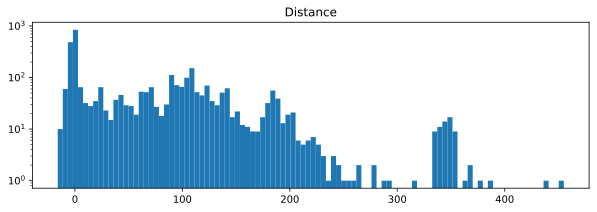

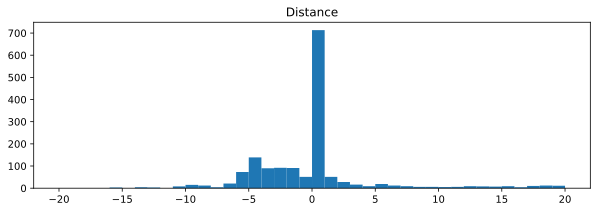

In [8]:
import matplotlib.pyplot as plt 

# Find the hits with the maximum overlap (below our threshold)
dists = []
countShort = 0
countAdjacent = 0
countTotal = 0
adjhit = None
for (subdir, read, hits) in getAllPrimerMatches():
    hits.sort(key=lambda h: h.start)
    for i in range(len(hits)-1):
        countTotal += 1
        dist = hits[i+1].start - hits[i].end
        if dist < 20:
            countShort += 1
        if dist <= 0:
            countAdjacent += 1
        dists.append(dist)
        if dist == 0 and adjhit == None:
            adjhit = (read, hits[i], hits[i+1])

aligner = Align.PairwiseAligner(mode='local', match_score=1, mismatch_score=0, gap_score=-1)
print(adjhit[1].primer.description)
print(aligner.align(adjhit[0].seq, adjhit[1].primer.rcSeq if adjhit[1].rev else adjhit[1].primer.seq)[0])
print(adjhit[2].primer.description)
print(aligner.align(adjhit[0].seq, adjhit[2].primer.rcSeq if adjhit[2].rev else adjhit[2].primer.seq)[0])

print("%d%% < 20bp" % int(100*countShort/countTotal))
print("%d%% <= 0bp" % int(100*countAdjacent/countTotal))

df = pd.DataFrame({'Distance': dists})
df.hist(bins=100, grid=False, log=True, figsize=(10,3))
df.hist(bins=40, grid=False, range=(-20,20), figsize=(10,3));

Primer dimers are still very common in this run, but by ignoring reads shorter than 200bp we've filtered out more of them.

## How much do primer hits overlap below our threshold?
Partial overlap of primer hits is an indication of primer-dimers, which we should expect to be more common at lower overlap ratios. High or total overlapping primer hits would come from primers targetting different variants of the same locus, but we filter out such overlaps early. Look for any evidence that we haven't filtered out enough.

Max overlap score: 0.76, read b494a3da-64e0-461b-911f-bdfcb7fe857c, len 387, suffix 42
Legionelle pneumophila 1 mr=1.00
target           68 ACCGATGCCACATCATTAGCT 89
                  0 ||||||||||||||||||||| 21
query             0 ACCGATGCCACATCATTAGCT 21

Human respiratory syncytial virus 2 (rev) mr=0.81
target           73 TGCCACATCATTAGCTCAAGTCAATGA 100
                  0 ||...|||||.||.|||||||||||||  27
query             0 TGATGCATCAATATCTCAAGTCAATGA  27

Chlamydophila pneumoniae 1 (rev) mr=1.00
target          100 CAGTCTTATAATTGATTTCTAGCCGTTG 128
                  0 ||||||||||||||||||||||||||||  28
query             0 CAGTCTTATAATTGATTTCTAGCCGTTG  28

Influenza A virus 2 mr=1.00
target          128 CTGGTGCACTTGCCAGCTG 147
                  0 |||||||||||||||||||  19
query             0 CTGGTGCACTTGCCAGCTG  19

Legionelle pneumophila 1 (rev) mr=0.81
target          325 AGCTAATGATG-GTAATCGGT 345
                  0 |||||||||||-|..||||||  21
query             0 AGCTAATGATGTGGCATCGGT  2

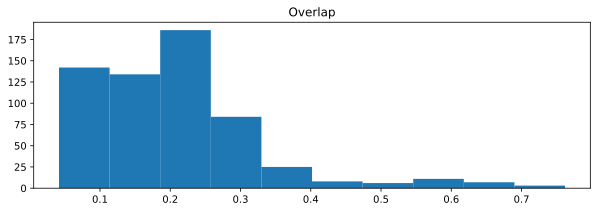

In [9]:
# Find the hits with the maximum overlap (below our threshold)
overlaps = []
maxo = 0
maxhit = None
for (subdir, read, hits) in getAllPrimerMatches():
    for i in range(len(hits)):
        for j in range(i):
            o = RCUtils.computeOverlap(hits[i],hits[j])
            if o > 0:
                overlaps.append(o)
                if o > maxo:
                    maxo = o
                    maxhit = (read, hits)

maxoend = max([h.end for h in maxhit[1]])
print("Max overlap score: %.2f, read %s, len %d, suffix %d" % 
      (maxo, maxhit[0].id, len(maxhit[0].seq), len(maxhit[0].seq) - maxoend))
for hit in sorted(maxhit[1], key=lambda h: h.start):
    print("%s%s mr=%.2f" % (hit.primer.description, " (rev)" if hit.rev else "", hit.mr))
    print(aligner.align(maxhit[0].seq, hit.primer.rcSeq if hit.rev else hit.primer.seq)[0])
      
pd.DataFrame({'Overlap': overlaps}).hist(figsize=(10,3), grid=False);

As expected, most overlap is by a small amount - just a few bases.
Looking at the read with the maximum overlap just below our 80% cutoff, it appears to be a quadruper primer-dimer combined with an off-target match. 

## What's the distribution of spans between possible primer pairs

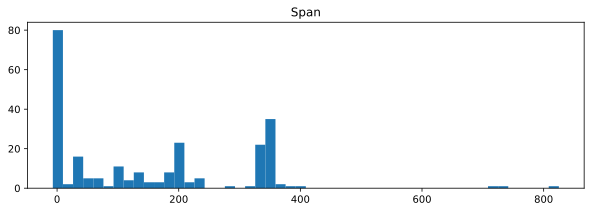

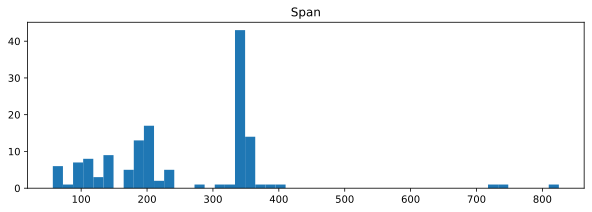

In [10]:
spans = []
for (subdir, read, hit1, hit2, span, pairname) in RCUtils.getPrimerPairs(primers, fastQBaseDir):
    spans.append(span)

df = pd.DataFrame({'Span': spans})
df.hist(bins=50, grid=False, figsize=(10,3));
df[df["Span"]>50].hist(bins=50, grid=False, figsize=(10,3));

There's one obvious cluster around 350bp.

## Find the primer pairs that occur most often per subdir and analyze their spans
For any given primer pair we expect the (distance in the read from start of first primer to end of second) to be consistent from read to read in true matches, but possibly more variable for mispriming.  

In [11]:
from collections import defaultdict
import statistics

perSubdirPrimer = defaultdict(lambda:{"count":0, "spans":[], "mrs":[], "readIds":[]})
totalPairs = 0
likelyPairs = 0
goodPairs = 0

for (subdir, read, hit1, hit2, span, pairname) in RCUtils.getPrimerPairs(primers, fastQBaseDir):
    totalPairs += 1
    if (span > 50):
        row = perSubdirPrimer[(subdir, pairname)]
        row["spans"].append(span)
        row["mrs"].append(hit1.mr)
        row["mrs"].append(hit2.mr)
        row["readIds"].append(read.id)

known_good_subdir_pairs = set()
known_good_reads = set()
table = {"Subdir":[], "PrimerPair":[], "Count":[], "SpanMedian":[], "SpanSD":[], "MRMedian":[]}
for ((subdir, primerpair),row) in perSubdirPrimer.items():
    count = len(row["spans"])
    if count > 1:
        likelyPairs += count
        table["Subdir"].append(subdir)
        table["PrimerPair"].append(primerpair)
        table["Count"].append(count)
        spans = row["spans"]
        table["SpanMedian"].append(round(statistics.median(spans)))
        table["SpanSD"].append(round(statistics.pstdev(spans)))
        table["MRMedian"].append(round(statistics.median(row["mrs"]), ndigits=2))
    if count > 5:
        goodPairs += count
        known_good_subdir_pairs.add((subdir, primerpair))
        known_good_reads |= set(row["readIds"])

print("Showing %d of %d possible pairs (%d%%), with %d known good" % 
      (likelyPairs, totalPairs, int(100*likelyPairs/totalPairs), goodPairs))
df = pd.DataFrame(data=table)
df.set_index(["Subdir","PrimerPair"], inplace=True)
df.sort_values("Count", ascending=False, inplace=True)
df

Showing 96 of 243 possible pairs (39%), with 53 known good


Count  SpanMedian  SpanSD  MRMedian
Subdir    PrimerPair                                                     
barcode08 Rhinovirus/Enterovirus 1/3     35         343       5      1.00
barcode04 Rhinovirus/Enterovirus 1/3     18         350      90      0.97
barcode01 Influenza A virus 2/13          5         197       3      0.96
barcode06 Influenza A virus 2/13          4         202       3      0.91
barcode07 Human adenovirus 6/9            4         192       3      1.00
barcode08 Rhinovirus/Enterovirus 2/3      3         347     179      0.95
barcode03 Influenza A virus 2/13          3         197      20      0.96
barcode02 Human parechovirus 1/2          3         104       0      0.95
          Influenza A virus 2/13          3         202       4      0.96
barcode03 Influenza A virus 2/7           2         200      20      1.00
barcode05 Influenza A virus 2/13          2         198       0      0.98
barcode02 SARS coronavirus 1/2 3/6        2         130      18      1.00
barcode06 SARS coronavirus 1/2 1/6        2          66       3      1.00
          Human adenovirus 7/11           2         480     346      0.90
barcode07 Influenza A virus 2/13          2         162      34      0.96
          Rhinovirus/Enterovirus 1/3      2         343       3      1.00
barcode08 Human adenovirus 6/9            2         198       4      1.00
barcode01 Hantaan virus 1/4               2          84      14      1.00

Here we see true Rhinovirus hits in barcode08 (already known from prior tests) and barcode04. Expected span 353bp. 

## Do known good reads ever have more than 2 primer hits?

In [12]:
from collections import defaultdict
hitCounts = defaultdict(int)
for (subdir, read, hits) in getAllPrimerMatches():
    if (read.id in known_good_reads):
        if len(hits) > 2:
            hits.sort(key=lambda h: h.start)
            print("%s read %s (len %d)" % (subdir, read.id, len(read.seq)))
            for hit in hits:
                print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))

barcode04 read 443d29fa-95d9-446a-844c-a14fef92150b (len 637)
   1.00 106-127: Rhinovirus/Enterovirus 3 (21)
   0.90 483-503: Rhinovirus/Enterovirus 1 (21 rev)
   0.83 543-560: Human adenovirus 9 (18)
   0.95 592-612: Human parechovirus 1 (19 rev)
barcode04 read 3bb733b2-8ea6-4dd4-a7e2-ba87df3b3c1e (len 895)
   1.00 67-88: Rhinovirus/Enterovirus 3 (21)
   1.00 457-478: Rhinovirus/Enterovirus 3 (21)
   0.90 829-849: Rhinovirus/Enterovirus 1 (21 rev)
barcode04 read b32c490c-b445-45f1-9678-b4b5f1251eac (len 543)
   0.95 66-86: Rhinovirus/Enterovirus 1 (21)
   1.00 436-457: Rhinovirus/Enterovirus 3 (21 rev)
   0.86 470-492: Rhinovirus/Enterovirus 2 (21 rev)
barcode08 read 320a16fc-68dc-4c1a-8fef-af2513dc13ab (len 882)
   1.00 70-91: Rhinovirus/Enterovirus 1 (21)
   1.00 445-466: Rhinovirus/Enterovirus 3 (21 rev)
   0.90 466-485: Human coronavirus 229E 1 (20)
   0.89 631-648: Influenza A virus 2 (19 rev)
   0.95 649-668: Influenza A virus 2 (19)
   0.94 794-813: Human adenovirus 7 (18 rev)


It's apparently quite common to have concatenated reads combining good target hits with off-target hits. It's also apparently common to have some primer-dimers attached to the primers from good reads.

## What's the cause of the high span deviation in barcode04?

In [13]:
table = {"Read":[], "Len":[], "Span":[]}
for (subdir, read, hit1, hit2, span, pairname) in RCUtils.getPrimerPairs(primers, fastQBaseDir, "barcode04"):
    if (pairname=="Rhinovirus/Enterovirus 1/3"):
        table["Read"].append(read.id)
        table["Len"].append(len(read))
        table["Span"].append(span)

df = pd.DataFrame(data=table)
df.set_index("Read", inplace=True)
df.sort_values("Span", inplace=True)
df

,Len,Span
Read,,
6e37d5be-28ec-4d77-ba09-37a5d8300663,957,335
bcafd0eb-5c18-4968-aec5-e6a7d6c65e6e,472,336
935e0457-2ef7-40bb-8ffa-9b088bf910a5,475,343
cae6b850-bf90-4494-8c9e-69d9dd4769d4,483,345
0569e872-7774-4477-83b3-33e7ac708bed,490,349
b32c490c-b445-45f1-9678-b4b5f1251eac,543,349
4124de8d-ea95-4782-88dc-c13b6b425785,487,349
3bb733b2-8ea6-4dd4-a7e2-ba87df3b3c1e,895,350
9a5fca45-003f-421e-92f4-4f55ccce7300,488,350


It looks like one read is a real outlier and others are shorter. Let's visualize this with an alignment

In [14]:
def hitString(hit):
    return "%s%s [%d,%d] (%.2f)" % (hit.primer.description, " (rev)" if hit.rev else "", hit.start, hit.end, hit.mr)

match1 = None
match2 = None
for (subdir, read, hit1, hit2, span, pairname) in RCUtils.getPrimerPairs(primers, fastQBaseDir, "barcode04"):
    if read.id=="5efec6dd-d30f-409b-a6d3-6fbec0ab345d":
        print(">" + hitString(hit1) + " - " + hitString(hit2))
        match1 = read[hit1.end:hit2.start]
    if read.id=="3bb733b2-8ea6-4dd4-a7e2-ba87df3b3c1e":
        longReadToStudy = read
        print(">" + hitString(hit1) + " - " + hitString(hit2))
        match2 = read[hit1.end:hit2.start]
print(aligner.align(match1.seq, match2.seq, "-")[0])

>Rhinovirus/Enterovirus 1 [67,89] (0.81) - Rhinovirus/Enterovirus 3 (rev) [443,464] (1.00)
>Rhinovirus/Enterovirus 3 [67,88] (1.00) - Rhinovirus/Enterovirus 1 (rev) [829,849] (0.90)
>Rhinovirus/Enterovirus 3 [457,478] (1.00) - Rhinovirus/Enterovirus 1 (rev) [829,849] (0.90)
target            1 ACCCTCGTATACGCTTCACCCGAGGCGAAAAATGAGGTTATCAATTTCCACCGAAATTGC
                  0 |...||||||||||||||||||||||||||||||||||||||.-||.||..|-|||.|||
query           349 AATTTCGTATACGCTTCACCCGAGGCGAAAAATGAGGTTATCG-TTACCCGC-AAAGTGC

target           61 CACCTGAGAAACCTAGTAGCATTTTTGAAGCCTATGGTTGGTCGCTCAACTGTTTGCAAC
                 60 |..|-||||||||||||||||||||||||||||||||||||||||||||||||||.|.-|
query           291 CTAC-GAGAAACCTAGTAGCATTTTTGAAGCCTATGGTTGGTCGCTCAACTGTTTACC-C

target          121 CCCAGTAGACCTGGCAGATGAGGCTAGATGTTCCCC-CTTGCTGATGAGTGATCTGGCCT
                120 ..||||||||||||||||||||||||||||||||||-|..||-||||-|||||||.||..
query           233 AGCAGTAGACCTGGCAGATGAGGCTAGATGTTCCCCACCAGC-GATG-GTGATCT

The long read matches well at the end, but what's the extra stuff at the start?

In [15]:
print(match2.seq)


TGGTTCCATCCATAGTTGCCCATTACGACTGCAGACATGTTGGATTACATGCAACAGCTACGGGGTTAGGATTAGCCACATTCAGGGGCGGAGGACTCAAAGTGAGCACAATAGACTCTTCACACCTTGTCCGCTTTCTGGCTTCACACTCAATAGAGTGTGCAGGCAACCACGCGAGCTAGATCACCATCGCTGGTGGGGAACATCTAGCCTCATCTGCCAGGTCTACTGCTGGGTAAACAGTTGAGCGACCAACCATAGGCTTCAAAAATGCTACTAGGTTTCTCGTAGGCACTTTGCGGGTAACGATAACCTCATTTTTCGCCTCGGGTGAAGCGTATACGAAATTTT


Ah, doing a blast search I see the same sequence is duplicated, so we have a concatemer of two hits. `computePrimerHits` returns at most one hit per primer with a TODO to find others.  Are there are other primer matches in this read?

In [16]:
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq, MutableSeq

ms = MutableSeq(longReadToStudy.seq)
hits = []
while True:
    newHits = RCUtils.computePrimerHits(SeqRecord(ms), primers, True)
    if len(newHits) == 0:
        break
    for hit in newHits:
        ms[hit.start:hit.end]="N" * (hit.end-hit.start)
    hits += newHits

hits.sort(key=lambda h: h.start)
for hit in hits:
    print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))


   1.00 67-88: Rhinovirus/Enterovirus 3 (21)
   1.00 457-478: Rhinovirus/Enterovirus 3 (21)
   0.90 829-849: Rhinovirus/Enterovirus 1 (21 rev)


Interesting, there's no matching reverse primer for the first half.

# Summary
From everything we've computed above, generate summary stats for each subdir.

In [17]:
statsPerSubdir = defaultdict(lambda: defaultdict(int))
for (subdir, read, hits) in getAllPrimerMatches():
    stats = statsPerSubdir[subdir]
    stats["reads"] += 1
    stats["bases"] += len(read.seq)
    if len(hits) > 0:
        stats["withHits"] += 1

        # Calculate total bases covered by all hits
        hitBases = 0
        for hit in hits:
            hitBases += hit.end - hit.start

        if len(hits) > 1:
            stats["withMultipleHits"] += 1
            hits.sort(key=lambda h: h.start)
            # Compute max distance between end of one hit and start of next
            maxSpan = 0
            for i in range(len(hits)-1):
                span = hits[i+1].start - hits[i].end
                if span < 0:
                    hitBases += span # Subtract overlap to avoid double-counting
                else:
                    stats["spanBases"] += span
                maxSpan = max(maxSpan, span)
            if maxSpan > 0:
                stats["withSpan"] += 1
                if maxSpan > 50:
                    stats["withSpanOver50"] += 1
        stats["hitBases"] += hitBases

    stats["knownGood"] += 1 if read.id in known_good_reads else 0

relStatsPerSubdir = defaultdict(dict)
for (subdir, stats) in statsPerSubdir.items():
    rs = relStatsPerSubdir[subdir]
    rs["reads"] = stats["reads"]
    rs["no hits"] = (stats["reads"] - stats["withHits"]) / stats["reads"]
    rs["lone hit"] = (stats["withHits"] - stats["withMultipleHits"]) / stats["reads"]
    rs["only dimers"] = (stats["withMultipleHits"] - stats["withSpan"]) / stats["reads"]
    rs["short span"] = (stats["withSpan"] - stats["withSpanOver50"]) / stats["reads"]
    rs["off target"] = (stats["withSpanOver50"] - stats["knownGood"]) / stats["reads"]
    rs["good"] = stats["knownGood"] / stats["reads"]
    rs["primer bases"] = stats["hitBases"] / stats["bases"]
    rs["span bases"] = stats["spanBases"] / stats["bases"]
pd.options.display.float_format = '{:.1%}'.format
pd.DataFrame.from_dict(relStatsPerSubdir, orient='index')

,reads,no hits,lone hit,only dimers,short span,off target,good,primer bases,span bases
barcode01,502,2.8%,32.5%,1.6%,3.4%,59.8%,0.0%,14.2%,30.2%
barcode02,240,2.1%,26.7%,3.3%,13.8%,54.2%,0.0%,15.2%,26.9%
barcode03,369,3.8%,38.2%,3.0%,6.5%,48.5%,0.0%,14.5%,23.8%
barcode04,251,3.2%,32.7%,4.0%,6.8%,46.6%,6.8%,13.5%,29.4%
barcode05,179,7.3%,25.1%,6.1%,7.8%,53.6%,0.0%,17.0%,23.9%
barcode06,341,2.6%,28.7%,7.6%,12.6%,48.4%,0.0%,18.8%,25.3%
barcode07,408,3.4%,31.6%,4.9%,10.3%,49.8%,0.0%,16.0%,25.2%
barcode08,299,3.0%,25.4%,9.0%,10.4%,40.5%,11.7%,16.0%,29.9%
